### Import necessary libraries

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model, Model, Sequential

from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.resnet import ResNet101
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers, regularizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import DistanceMetric, accuracy_score, precision_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import gym
from gym import spaces

In [2]:
def test_model(model, val_X, val_Y, class_names):
    
    preds = model.predict(val_X)
    # Convert predicted probabilities to predicted class labels
    pred_labels = []
    for pl in preds:
        x = np.zeros(len(class_names), dtype="int8")
        x[np.argmax(pl)] = 1
        pred_labels.append(x)
    p_l = [np.where(x == 1)[0][0] if np.where(x == 1)[0].size > 0 else 0 for x in pred_labels]
    t_l = [np.where(x == 1)[0][0] for x in val_Y]
    
    accuracy = accuracy_score(val_Y, pred_labels)
    
    # Calculate precision
    precision = precision_score(val_Y, pred_labels, average='micro')
    
    # Calculate F1 score
    f1 = f1_score(val_Y, pred_labels, average='micro')
    
    # Calculate AUC-ROC
    auc_roc = roc_auc_score(val_Y, pred_labels, average='micro')
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(t_l, p_l)
    
    
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Confusion Matrix')
    plt.show()
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("F1 Score:", f1)
    print("AUC-ROC Score:", auc_roc)
    print("Confusion Matrix:")
    print(conf_matrix)

### Define MyEnv class

In [3]:
class MyEnv(gym.Env):
    def __init__(self, images, labels):
        # super(myEnv, self).__init__()
        self.timestep_limit = len(labels) or 100
        self.images = images
        self.labels = labels
        self.num_classes = len(np.unique(labels))
        self.action_space = spaces.Discrete(self.num_classes)
        self.observation_space = spaces.Box(low=0, high=255, shape=images[0].shape, dtype=np.uint8)
        self.current_step = 0
    
    def reset(self):
        self.current_step = 0
        obs = self.images[self.current_step]
        return obs
    
    def step(self, action):
        reward = self._get_reward(action)
        done = self.current_step == len(self.images) - 1
        obs = self.images[self.current_step]
        self.current_step += 1
        return obs, reward, done, {}
    
    def _get_reward(self, action):
        if np.argmax(action) == np.argmax(self.labels[self.current_step]):
            return 1
        else:
            return -1


### Define Dataloader Base class to load image data

In [4]:
class DataLoaderBase:
    def __init__(self, dataset_path, image_size=(224, 224), batch_size=64, data_size = 0):
        self.dataset_path = dataset_path
        self.config = { "image_size": image_size, "batch_size": batch_size }
        # define ImageDataGenerator object for lading image data
        self.data_gen = ImageDataGenerator(
          rescale=1./255,
          width_shift_range=0.1,
          height_shift_range=0.1,
          # shear_range=0.1,
          zoom_range=0.2,
          # horizontal_flip=True,
          fill_mode='nearest',
          validation_split=(1-data_size)
        )
        self.data = self.data_gen.flow_from_directory(
          self.dataset_path,
          subset="training", # using this param just to get the selected portion of total dataset
          class_mode='categorical', # 'sparse', # 'categorical'
          target_size=self.config['image_size'],
          batch_size=self.config['batch_size'],
          shuffle=True,
        )
        self.num_classes = self.data.num_classes
        self.class_names = list(self.data.class_indices.keys())
        print("Total classes:", self.num_classes, self.class_names)

        self.images, self.labels = [], []
        print("{} Preparing Data {}".format('#'*15, '#'*15))
        for idx in range(len(self.data)):
            batch_X, batch_Y = self.data.next()
            self.images.append(batch_X)
            self.labels.append(batch_Y)
        
        self.images = np.concatenate(self.images)
        self.labels = [x.astype(np.int8) for x in np.concatenate(self.labels)] # converting [0.0 1.0 0.0] => [0 1 0]
        print("{} Data Preparation completed {}".format('#'*15, '#'*15))

### Define Expert Class

In [5]:
class Expert(DataLoaderBase):

    def __init__(self, image_size, batch_size, dataset_size, is_human_expert):
        dataset_path = "../../dataset/xray_new/COVID_19_Radiography_Dataset_Refined/train"
        model_path = "./models/xray_vgg16_64_12_expert_acc_95.7.h5"
        DataLoaderBase.__init__(self, dataset_path, image_size, batch_size, dataset_size)
        self.config["is_human_expert"] = is_human_expert
        self.n_rollouts = 2
        self.model = load_model(model_path)

    def policy_fn(self, input, data_idx):
        expert_output = [0, 0, 0]
        if self.config["is_human_expert"]: # human expert
            # just returning output based on predefined label
            expert_output = self.labels[data_idx]
            return expert_output
        else: # using pretrained expert model
            expert_output = np.zeros(self.num_classes, dtype="int8") # [0, 0, 0]
            predictions = self.model.predict(input, verbose=0) # [[0.01, 0.98, 0.32]]
            predicted_index = np.argmax(predictions[0])
            expert_output[predicted_index] = 1
            return expert_output
        
    def get_demonstrations(self):
        # read normalized image data and labels from demo_generator
        env = MyEnv(self.images, self.labels)
        
        max_steps = env.timestep_limit

        observations, actions, rewards = [], [], []

        # Demonstrating the expert
        print("Preparing demonstration data by expert")
        for rollout in range(1, self.n_rollouts):
            # predict on bulk if pretained expert model is being used
            if self.config['is_human_expert']:
                predictions = self.model.predict(self.images) # [[0.01, 0.98, 0.32], [0.71, 0.098, 0.032]]
                
                obs = env.reset()
                
                done, total_reward, steps = False, 0, 0
                while not done:
                    action = self.policy_fn(obs[None,:], env.current_step)
                    obs, reward, done, _ = env.step(action)
                    observations.append(obs)
                    actions.append(action)
                    total_reward += reward
                    steps += 1
                    if steps % 100 == 0:
                        print("%i/%i"%(steps, max_steps))
                    if steps >= max_steps:
                        break
                rewards.append(total_reward)
            else:
                observations.extend(self.images)
                predictions = self.model.predict(self.images) # [[0.01, 0.98, 0.32], [0.71, 0.098, 0.032]]
                actions_temp = []
                reward_temp = 0
                for i, pred in enumerate(predictions):
                    output_temp = np.zeros(self.num_classes, dtype="int8") # [0, 0, 0]
                    predicted_index = np.argmax(pred)
                    output_temp[predicted_index] = 1
                    actions_temp.append(output_temp)
                    if predicted_index == np.argmax(self.labels[i]):
                        reward_temp += 1
                actions.extend(actions_temp)
                rewards.append(reward_temp)
                
        print("Expert reward: {}".format(np.average(rewards)))
        print("Expert expected reward: {}".format(len(self.labels)))
        return {"observations": np.array(observations), "actions": np.array(actions)}

### Define DAgger class

In [17]:
class DAgger(DataLoaderBase):

    def __init__(self, expert, image_size, batch_size, dataset_size = 1):
        dataset_path = "../../dataset/xray_new/COVID_19_Radiography_Dataset_Unseen/"
        DataLoaderBase.__init__(self, dataset_path, image_size, batch_size, dataset_size)
        self.config["is_human_expert"] = expert.config['is_human_expert']
        self.curr_state = expert.get_demonstrations()
        self.surr_loss = DistanceMetric.get_metric('euclidean')
        self.train_X, self.test_X, self.train_Y, self.test_Y = train_test_split(self.images, self.labels, test_size=0.3, shuffle=True)
        self.new_data_batch = int(len(self.train_Y)/9)
        self.train_epochs = 10
        self.n_rollouts = int(len(self.train_Y)/self.new_data_batch) + 1
        self.p = 0.9 # probability of using the expert (value recommended on section 5 of https://arxiv.org/pdf/1011.0686.pdf)
        
        # to query the expert, defining expert
        self.expert_policy = self.expert_policy() if self.config["is_human_expert"] else expert.model

    def score_policy(self, model):
        predicted_actions = model.predict(self.test_X)
        expected_actions = np.array(self.test_Y)
        scores = []
        for i in range(len(predicted_actions)):
            score = self.surr_loss.pairwise([predicted_actions[i]], [expected_actions[i]])
            scores.append(score)
        return np.mean(scores)

    def expert_policy(self):
        # this train the mod
        # expert_model = self.train_model(self.base_model(), True)
        # expert_model.save("./models/expert_policy.h5")
        expert_model = lambda acts: np.array(acts)
        return expert_model
    
    def train(self):

        self.build_network()
        print("Imitating expert observations....")
        # mimicing the expert's feature
        self.dagger_policy = self.train_model(self.dagger_policy)
        print("Imitating expert observations DONE!!!")
        best_score, best_dagger_model = self.score_policy(self.dagger_policy), self.dagger_policy
        print("Initial Best score: ", best_score)

        '''
        dagger_model = self.train_model(self.dagger_policy)
        
        score = self.score_policy(dagger_model)
        print("New Policy Score:", score)

        if score < best_score:
            best_score = score
            best_dagger_model = dagger_model
        print("New Best Policy Score:",  best_score)
        '''
        return best_dagger_model

    def base_model(self):
        input_shape = self.config['image_size']
        # choose one of the base models
        base_model = VGG16(input_shape=input_shape + (3,), include_top=False, weights ='imagenet')
        # base_model = ResNet101(input_shape=input_shape, include_top=False, weights='imagenet')
        # base_model = DenseNet169(input_shape=input_shape, include_top=False, weights ='imagenet')

        # freeze layers of base model as training is not needed for them
        for layer in base_model.layers:
          layer.trainable = False

        '''
        # Make some customization on the output layer of base Model
        x = base_model.output
        # x = GlobalAveragePooling2D()(x)
        # x = MaxPooling2D()(x)
        # x = Dense(1024, activation='relu')(x)
        x = Flatten()(x)

        x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.02))(x)
        x = Dropout(0.5)(x)
        predictions = Dense(self.num_classes, activation='softmax')(x)

        # Initialize model based on base Model
        model = Model(inputs=base_model.input, outputs=predictions)
        '''
        model = Sequential([
            base_model,
            Flatten(),
            Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            Dropout(0.5),  # Add dropout layer for regularization
            Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            Dropout(0.5),  # Add dropout layer for regularization
            Dense(self.num_classes, activation='softmax')
        ])

        # Compile model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def build_network(self):
        self.dagger_policy = self.base_model()
        '''
        self.dagger_policy = Sequential([
            # Convolutional layers
            Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            
            # Flatten the output of the convolutional layers
            Flatten(),
            
            # Fully connected layers
            Dense(64, activation='relu'),
            Dense(self.num_classes, activation='softmax')  # Output layer with number of classes
        ])
        self.dagger_policy.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        '''

    def train_model(self, model, is_expert=False):
        t_X, t_Y = self.curr_state['observations'], self.curr_state['actions']

        # adjusting class weights
        y_labels = [np.where(x == 1)[0][0] if np.where(x == 1)[0].size > 0 else 0 for x in t_Y]
        train_data_distribution = np.unique(y_labels, return_counts=True)
        class_weight = {key: train_data_distribution[1][key] for key in train_data_distribution[0]}
        print("Default class weight: {}".format(class_weight))
        
        class_weight = { key: class_weight[0]/class_weight[key] for key in class_weight.keys() }
        print("Balanced class weight: {}".format(class_weight))
        
        # customizing the weights
        class_weight = {0: class_weight[0]*1.1, 1: class_weight[1] * 1.2, 2: class_weight[2]}
        print("Custom class weight: {}".format(class_weight))

        history = model.fit(t_X, t_Y, epochs=self.train_epochs, batch_size=self.config['batch_size'], validation_split=0.2, shuffle=True, class_weight=class_weight)
       
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        return model

    def main(self):
        # training model with initial observations from expert
        learned_policy = self.train()

        # Initial test
        print("{} Testing learned model demons by expert {}".format('#'*15, '#'*15))
        test_model(learned_policy, self.test_X, self.test_Y, self.class_names)
        print("{} Testing learned model demons by expert DONE {}\n\n\n".format('*'*15, '*'*15))
        
        reward_dict = {}
        
        # aggregating data and retraining
        for rollout in range(1, self.n_rollouts + 1):
            print("{} Rollout: {} of {} {}".format('#'*15, rollout, self.n_rollouts, '#'*15))

            beta = 1 if rollout == 1 else self.p**(rollout - 1)
            print("Value of beta: {}".format(beta))
            
            current_policy = lambda is_human_expert, obs, acts: beta * (self.expert_policy(acts) if is_human_expert else self.expert_policy.predict(obs, verbose=0)) + (1 - beta) * learned_policy.predict(obs)

            # generate new dataset (new trajectories)
            start_index = (rollout - 1) * self.new_data_batch
            end_index = start_index + self.new_data_batch
            new_images, new_labels = self.train_X[start_index:end_index], self.train_Y[start_index:end_index]
            new_observations = new_images
            
            trajectory_actions = current_policy(self.config["is_human_expert"], new_observations, new_labels)

            # prepare new dataset with the help of expert policy
            if self.config["is_human_expert"]:
                new_actions = self.expert_policy(new_labels)
            else:
                new_actions = self.expert_policy.predict(new_observations, verbose=0) # [[0.01, 0.98, 0.32], [0.71, 0.098, 0.032]]
                new_actions = (new_actions > 0.5).astype(np.int8)

            # aggregating the data
            current_abservation_list =  list(self.curr_state["observations"])
            current_actions_list = list(self.curr_state["actions"])
            current_abservation_list.extend(new_observations)
            current_actions_list.extend(new_actions)
            self.curr_state["observations"] = np.array(current_abservation_list)
            self.curr_state["actions"] = np.array(current_actions_list)

            current_policy_preds = learned_policy.predict(new_observations, verbose=0)

            # evaluating expert's predictions and current policy's preds
            actions_temp, new_rewards = [], []
            reward_temp, current_count = 0, 0
            distribution_info = {"0": 0, "1": 0, "2": 0}
            for i, expert_pred in enumerate(new_actions):
                if np.argmax(new_labels[i]) == 0:
                    distribution_info['0'] += 1
                elif np.argmax(new_labels[i]) == 1:
                    distribution_info['1'] += 1
                else:
                    distribution_info['2'] += 1
                
                predicted_index = np.argmax(expert_pred)
                if predicted_index == np.argmax(new_labels[i]):
                    current_count += 1
                
                c_pred = current_policy_preds[i]
                c_pred_idx = np.argmax(c_pred)
                if c_pred_idx == np.argmax(new_labels[i]):
                    reward_temp += 1
            new_rewards.append(reward_temp)
            print("expert's accuracy = {}".format(current_count/len(new_labels)))

            # this is another way to add new data (one by one) but too slow
            '''
            env = MyEnv(new_images, new_labels)
            obs = env.reset()
            new_observations, new_actions, new_rewards = [], [], []
            
            done, total_reward, steps = False, 0, 0
            while not done:
                action = self.expert_policy(obs[None,:], env.current_step)
                new_observations.append(obs)
                new_actions.append(action)
                obs, reward, done, _ = env.step(action)
                total_reward += reward
                steps += 1
                if steps % 100 == 0:
                    print("%i/%i"%(steps, max_steps))
                if steps >= max_steps:
                    break
            new_rewards.append(total_reward)
            
            self.curr_state["observations"] = list(self.curr_state["observations"]).extend(new_observations)
            self.curr_state["actions"] = list(self.curr_state["actions"]).extend(new_actions)

            '''
            
            print(distribution_info)
            print("Training for rollout {} with {} of training data".format(rollout, len(self.curr_state["actions"])))
            learned_policy = self.train()
            print("Training completed for rollout {}".format(rollout))

            print("\n{} Testing learned model {}".format('#'*15, '#'*15))
            
            print("Reward: {}, Expected Reward: {}".format(np.mean(new_rewards), len(new_actions)))
            
            # calculate relative reward 
            reward_dict[rollout] = np.mean(new_rewards)/len(new_actions) * 100
            
            test_model(learned_policy, self.test_X, self.test_Y, self.class_names)
            print("{} Testing learned model done {}\n\n\n".format('*'*15, '*'*15))
            human_or_model = "human_expert" if self.config["is_human_expert"] else "model_expert"
            model_name = "./models/learned_policy_{}_rollout".format(human_or_model)
            learned_policy.save("{}_{}.h5".format(model_name, rollout))
        best_rollout = max(reward_dict, key=reward_dict.get)
        return "{}_{}.h5".format(model_name, best_rollout)

### Define some parameters

In [23]:
IMAGE_SIZE = (224, 224) # better to use same size as used in pretrained
BATCH_SIZE = 64
IS_HUMAN_EXPERT = False # flag whether to use pretained model or use simulated human
EXPERT_DATASET_SIZE = 0.5 # Total = 4495, take only x% data 
AGENT_DATASET_SIZE = 1 # Total = 2626, take only x% data

### Create an object of Expert

In [24]:
my_expert = Expert(IMAGE_SIZE, BATCH_SIZE, EXPERT_DATASET_SIZE, IS_HUMAN_EXPERT)

Found 2248 images belonging to 3 classes.
Total classes: 3 ['COVID', 'Normal', 'Viral Pneumonia']
############### Preparing Data ###############
############### Data Preparation completed ###############


### Create an object of DAgger

In [25]:
dagger = DAgger(my_expert, IMAGE_SIZE, BATCH_SIZE, AGENT_DATASET_SIZE)

Found 2666 images belonging to 3 classes.
Total classes: 3 ['COVID', 'Normal', 'Viral Pneumonia']
############### Preparing Data ###############
############### Data Preparation completed ###############
Preparing demonstration data by expert
71/71 [==============================] - 3s 34ms/step
Expert reward: 2220.0
Expert expected reward: 2248


### Train DAgger model

Imitating expert observations
{0: 1049, 1: 947, 2: 252}
{0: 1.0, 1: 1.1077085533262936, 2: 4.162698412698413}
{0: 1.1, 1: 1.3292502639915522, 2: 4.162698412698413}
Epoch 1/10
29/29 [==============================] - 4s 98ms/step - loss: 4.3793 - accuracy: 0.4905 - val_loss: 1.2813 - val_accuracy: 0.8000
Epoch 2/10
29/29 [==============================] - 2s 86ms/step - loss: 1.8668 - accuracy: 0.6974 - val_loss: 1.0901 - val_accuracy: 0.8644
Epoch 3/10
29/29 [==============================] - 2s 86ms/step - loss: 1.4808 - accuracy: 0.7709 - val_loss: 0.9269 - val_accuracy: 0.8511
Epoch 4/10
29/29 [==============================] - 2s 86ms/step - loss: 1.3547 - accuracy: 0.7753 - val_loss: 0.8862 - val_accuracy: 0.8622
Epoch 5/10
29/29 [==============================] - 2s 86ms/step - loss: 1.1414 - accuracy: 0.8237 - val_loss: 0.8022 - val_accuracy: 0.8689
Epoch 6/10
29/29 [==============================] - 2s 86ms/step - loss: 1.1276 - accuracy: 0.8265 - val_loss: 0.7811 - val_accurac

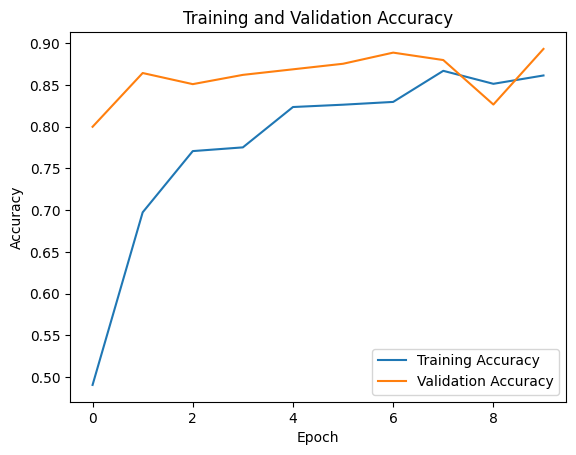

25/25 [==============================] - 1s 33ms/step
Initial Best score:  0.3771228151391621
############### Testing learned model demons by expert ###############
25/25 [==============================] - 1s 35ms/step


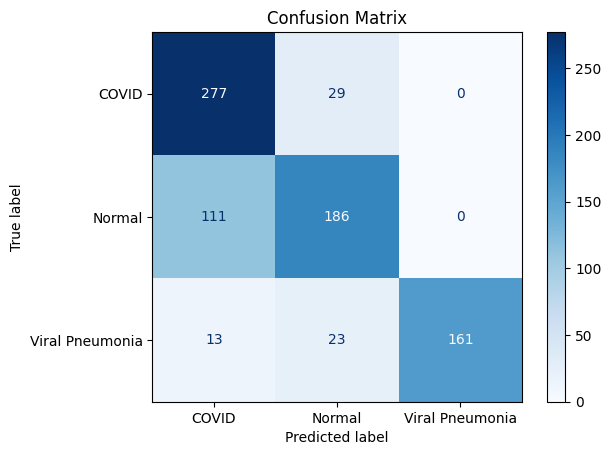

Accuracy: 0.78
Precision: 0.78
F1 Score: 0.78
AUC-ROC Score: 0.8350000000000001
Confusion Matrix:
[[277  29   0]
 [111 186   0]
 [ 13  23 161]]
*************** Testing learned model demons by expert DONE ***************



############### Rollout: 1 of 10 ###############
Value of beta: 1
7/7 [==============================] - 0s 35ms/step
expert's accuracy = 0.9178743961352657
{'0': 91, '1': 75, '2': 41}
Training for rollout 1 with 2455 of training data
Imitating expert observations
{0: 1136, 1: 1030, 2: 289}
{0: 1.0, 1: 1.1029126213592233, 2: 3.930795847750865}
{0: 1.1, 1: 1.323495145631068, 2: 3.930795847750865}
Epoch 1/10
31/31 [==============================] - 4s 99ms/step - loss: 4.3923 - accuracy: 0.5224 - val_loss: 1.3176 - val_accuracy: 0.7760
Epoch 2/10
31/31 [==============================] - 3s 87ms/step - loss: 1.7045 - accuracy: 0.7271 - val_loss: 1.1473 - val_accuracy: 0.7719
Epoch 3/10
31/31 [==============================] - 3s 87ms/step - loss: 1.3323 - accuracy: 0.80

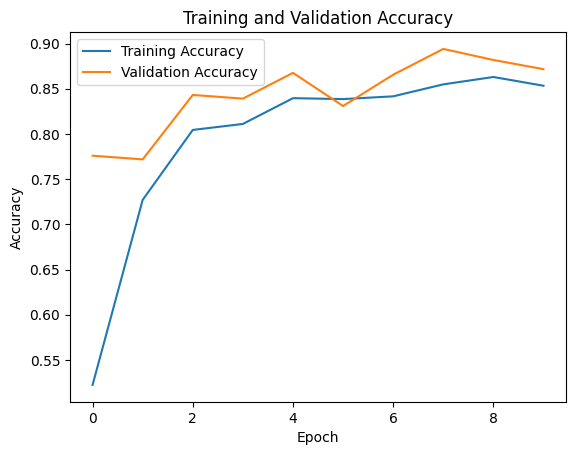

25/25 [==============================] - 1s 34ms/step
Initial Best score:  0.34106323988658505
Training completed for rollout 1

############### Testing learned model ###############
Reward: 155.0, Expected Reward: 207
25/25 [==============================] - 1s 34ms/step


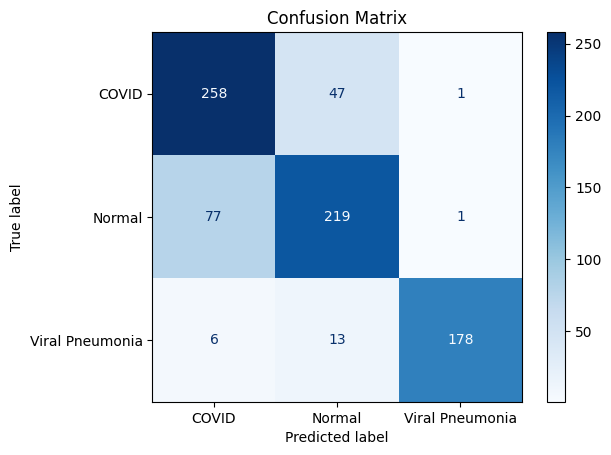

Accuracy: 0.81875
Precision: 0.81875
F1 Score: 0.81875
AUC-ROC Score: 0.8640625000000001
Confusion Matrix:
[[258  47   1]
 [ 77 219   1]
 [  6  13 178]]
*************** Testing learned model done ***************



############### Rollout: 2 of 10 ###############
Value of beta: 0.9
7/7 [==============================] - 0s 34ms/step
expert's accuracy = 0.893719806763285
{'0': 80, '1': 70, '2': 57}
Training for rollout 2 with 2662 of training data
Imitating expert observations
{0: 1215, 1: 1109, 2: 338}
{0: 1.0, 1: 1.0955816050495941, 2: 3.594674556213018}
{0: 1.1, 1: 1.3146979260595129, 2: 3.594674556213018}
Epoch 1/10
34/34 [==============================] - 4s 98ms/step - loss: 3.5287 - accuracy: 0.5317 - val_loss: 1.3430 - val_accuracy: 0.7054
Epoch 2/10
34/34 [==============================] - 3s 88ms/step - loss: 1.5588 - accuracy: 0.7313 - val_loss: 1.0822 - val_accuracy: 0.7824
Epoch 3/10
34/34 [==============================] - 3s 88ms/step - loss: 1.2837 - accuracy: 0.8032 - v

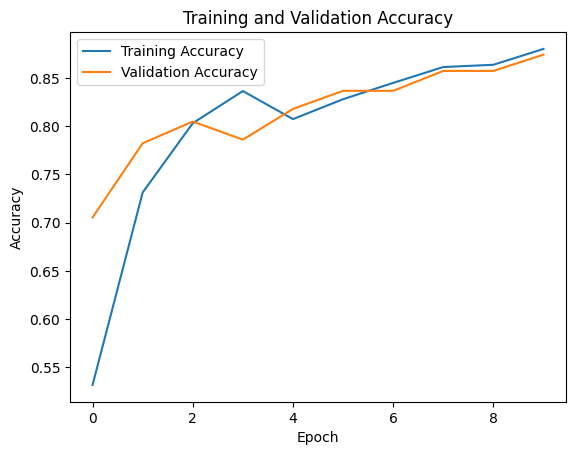

25/25 [==============================] - 1s 33ms/step
Initial Best score:  0.2712521560012423
Training completed for rollout 2

############### Testing learned model ###############
Reward: 166.0, Expected Reward: 207
25/25 [==============================] - 1s 33ms/step


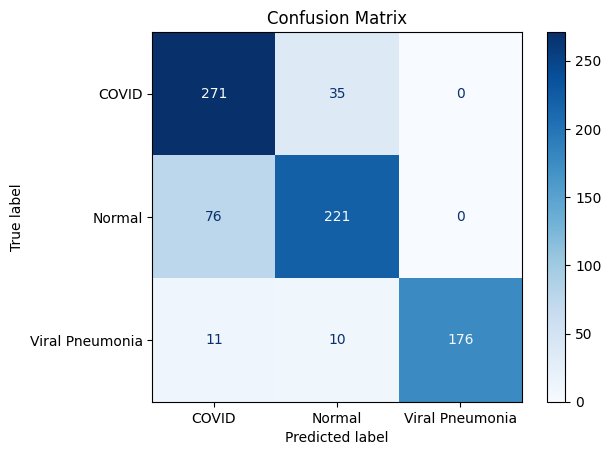

Accuracy: 0.835
Precision: 0.835
F1 Score: 0.835
AUC-ROC Score: 0.87625
Confusion Matrix:
[[271  35   0]
 [ 76 221   0]
 [ 11  10 176]]
*************** Testing learned model done ***************



############### Rollout: 3 of 10 ###############
Value of beta: 0.81
7/7 [==============================] - 0s 34ms/step
expert's accuracy = 0.8985507246376812
{'0': 76, '1': 83, '2': 48}
Training for rollout 3 with 2869 of training data
Imitating expert observations
{0: 1292, 1: 1197, 2: 380}
{0: 1.0, 1: 1.0793650793650793, 2: 3.4}
{0: 1.1, 1: 1.295238095238095, 2: 3.4}
Epoch 1/10
36/36 [==============================] - 4s 96ms/step - loss: 3.2634 - accuracy: 0.5525 - val_loss: 1.2557 - val_accuracy: 0.7683
Epoch 2/10
36/36 [==============================] - 3s 88ms/step - loss: 1.4437 - accuracy: 0.7569 - val_loss: 1.0412 - val_accuracy: 0.7787
Epoch 3/10
36/36 [==============================] - 3s 87ms/step - loss: 1.1831 - accuracy: 0.8000 - val_loss: 0.9729 - val_accuracy: 0.7544
Epoch

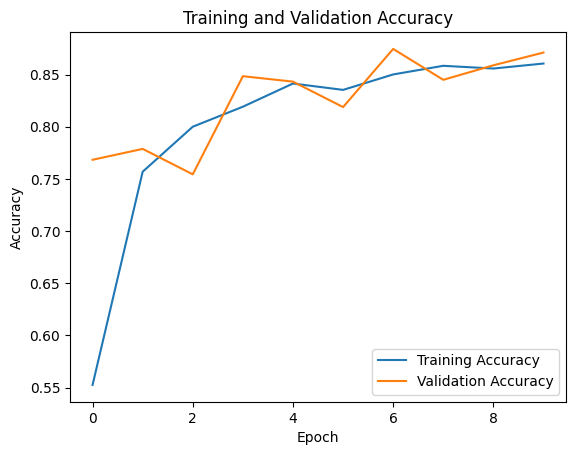

25/25 [==============================] - 1s 33ms/step
Initial Best score:  0.29479108085481154
Training completed for rollout 3

############### Testing learned model ###############
Reward: 170.0, Expected Reward: 207
25/25 [==============================] - 1s 34ms/step


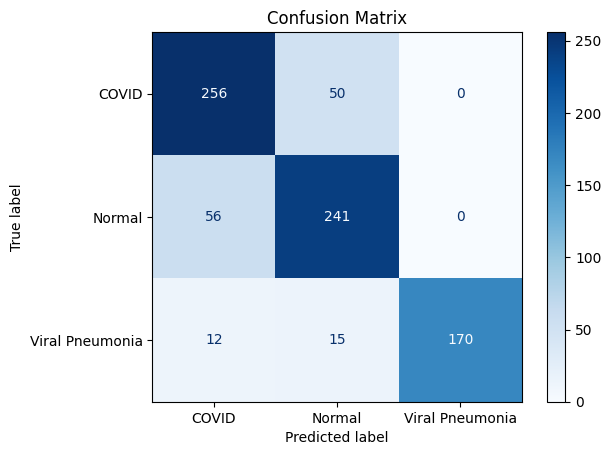

Accuracy: 0.83375
Precision: 0.83375
F1 Score: 0.83375
AUC-ROC Score: 0.8753125
Confusion Matrix:
[[256  50   0]
 [ 56 241   0]
 [ 12  15 170]]
*************** Testing learned model done ***************



############### Rollout: 4 of 10 ###############
Value of beta: 0.7290000000000001
7/7 [==============================] - 0s 33ms/step
expert's accuracy = 0.8888888888888888
{'0': 68, '1': 86, '2': 53}
Training for rollout 4 with 3076 of training data
Imitating expert observations
{0: 1370, 1: 1281, 2: 425}
{0: 1.0, 1: 1.0694769711163155, 2: 3.223529411764706}
{0: 1.1, 1: 1.2833723653395785, 2: 3.223529411764706}
Epoch 1/10
39/39 [==============================] - 4s 97ms/step - loss: 3.4689 - accuracy: 0.5691 - val_loss: 1.3193 - val_accuracy: 0.7679
Epoch 2/10
39/39 [==============================] - 3s 88ms/step - loss: 1.4794 - accuracy: 0.7537 - val_loss: 1.0491 - val_accuracy: 0.7906
Epoch 3/10
39/39 [==============================] - 3s 88ms/step - loss: 1.2064 - accuracy: 0.7

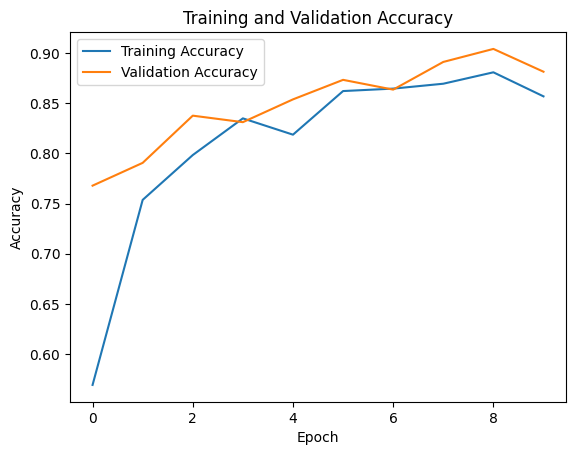

25/25 [==============================] - 1s 34ms/step
Initial Best score:  0.2973447119624693
Training completed for rollout 4

############### Testing learned model ###############
Reward: 171.0, Expected Reward: 207
25/25 [==============================] - 1s 34ms/step


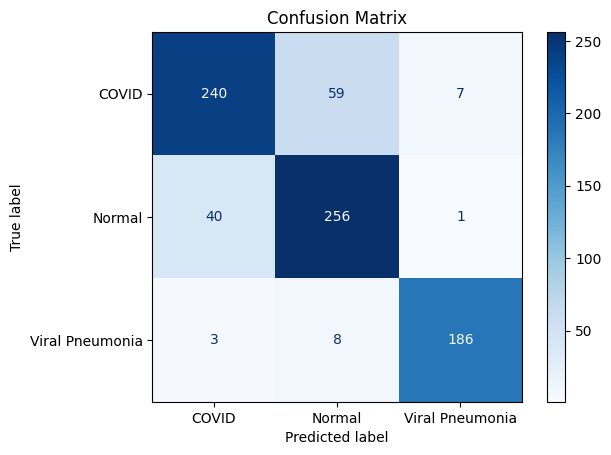

Accuracy: 0.8525
Precision: 0.8525
F1 Score: 0.8525
AUC-ROC Score: 0.889375
Confusion Matrix:
[[240  59   7]
 [ 40 256   1]
 [  3   8 186]]
*************** Testing learned model done ***************



############### Rollout: 5 of 10 ###############
Value of beta: 0.6561
7/7 [==============================] - 0s 34ms/step
expert's accuracy = 0.9227053140096618
{'0': 83, '1': 73, '2': 51}
Training for rollout 5 with 3283 of training data
Imitating expert observations
{0: 1458, 1: 1354, 2: 471}
{0: 1.0, 1: 1.0768094534711965, 2: 3.0955414012738856}
{0: 1.1, 1: 1.2921713441654357, 2: 3.0955414012738856}
Epoch 1/10
42/42 [==============================] - 5s 97ms/step - loss: 3.5124 - accuracy: 0.5480 - val_loss: 1.2324 - val_accuracy: 0.7580
Epoch 2/10
42/42 [==============================] - 4s 87ms/step - loss: 1.5744 - accuracy: 0.7300 - val_loss: 1.0206 - val_accuracy: 0.8082
Epoch 3/10
42/42 [==============================] - 4s 87ms/step - loss: 1.2438 - accuracy: 0.7883 - val_loss

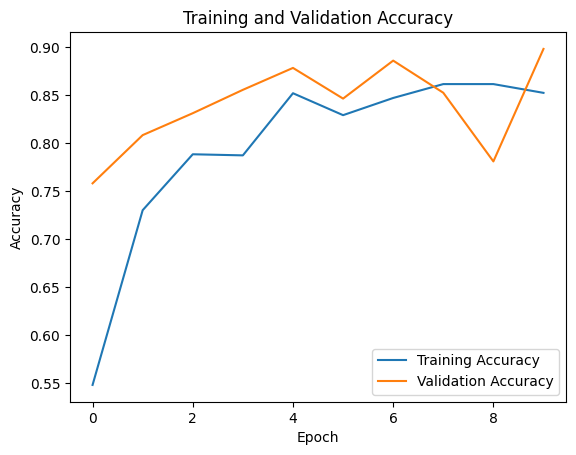

25/25 [==============================] - 1s 34ms/step
Initial Best score:  0.30127677541596365
Training completed for rollout 5

############### Testing learned model ###############
Reward: 181.0, Expected Reward: 207
25/25 [==============================] - 1s 34ms/step


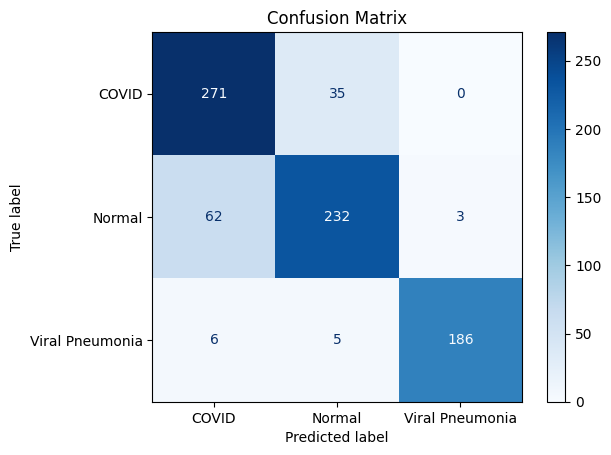

Accuracy: 0.86125
Precision: 0.86125
F1 Score: 0.86125
AUC-ROC Score: 0.8959375
Confusion Matrix:
[[271  35   0]
 [ 62 232   3]
 [  6   5 186]]
*************** Testing learned model done ***************



############### Rollout: 6 of 10 ###############
Value of beta: 0.5904900000000001
7/7 [==============================] - 0s 34ms/step
expert's accuracy = 0.9130434782608695
{'0': 72, '1': 81, '2': 54}
Training for rollout 6 with 3490 of training data
Imitating expert observations
{0: 1532, 1: 1441, 2: 517}
{0: 1.0, 1: 1.063150589868147, 2: 2.9632495164410058}
{0: 1.1, 1: 1.2757807078417764, 2: 2.9632495164410058}
Epoch 1/10
44/44 [==============================] - 5s 95ms/step - loss: 3.1341 - accuracy: 0.5734 - val_loss: 1.2037 - val_accuracy: 0.8052
Epoch 2/10
44/44 [==============================] - 4s 86ms/step - loss: 1.4237 - accuracy: 0.7683 - val_loss: 0.9730 - val_accuracy: 0.8195
Epoch 3/10
44/44 [==============================] - 4s 86ms/step - loss: 1.1292 - accuracy: 0.

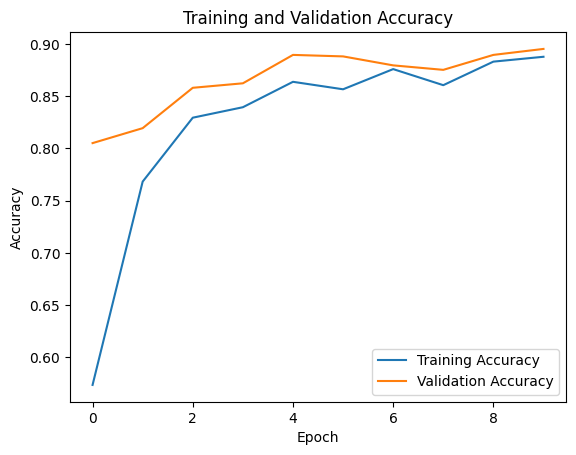

25/25 [==============================] - 1s 34ms/step
Initial Best score:  0.24280583903226508
Training completed for rollout 6

############### Testing learned model ###############
Reward: 181.0, Expected Reward: 207
25/25 [==============================] - 1s 34ms/step


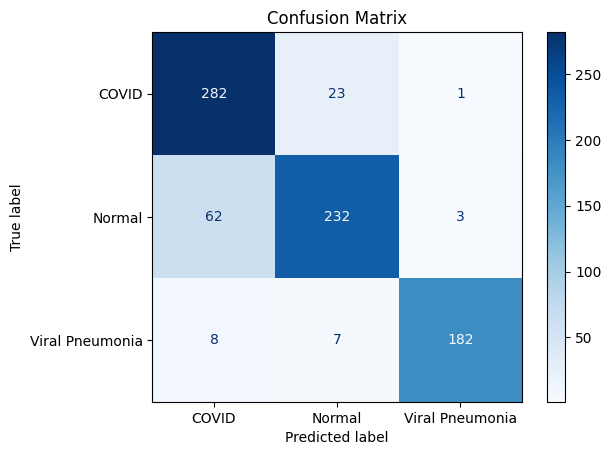

Accuracy: 0.87
Precision: 0.87
F1 Score: 0.87
AUC-ROC Score: 0.9025000000000002
Confusion Matrix:
[[282  23   1]
 [ 62 232   3]
 [  8   7 182]]
*************** Testing learned model done ***************



############### Rollout: 7 of 10 ###############
Value of beta: 0.531441
7/7 [==============================] - 0s 35ms/step
expert's accuracy = 0.9468599033816425
{'0': 85, '1': 75, '2': 47}
Training for rollout 7 with 3697 of training data
Imitating expert observations
{0: 1618, 1: 1520, 2: 559}
{0: 1.0, 1: 1.0644736842105262, 2: 2.894454382826476}
{0: 1.1, 1: 1.2773684210526315, 2: 2.894454382826476}
Epoch 1/10
47/47 [==============================] - 5s 96ms/step - loss: 2.9495 - accuracy: 0.5986 - val_loss: 1.1534 - val_accuracy: 0.7649
Epoch 2/10
47/47 [==============================] - 4s 87ms/step - loss: 1.3700 - accuracy: 0.7717 - val_loss: 0.9752 - val_accuracy: 0.8311
Epoch 3/10
47/47 [==============================] - 4s 87ms/step - loss: 1.1696 - accuracy: 0.8035 - val_

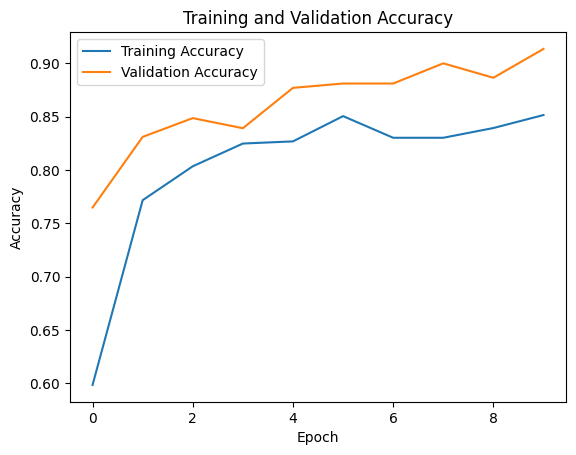

25/25 [==============================] - 1s 34ms/step
Initial Best score:  0.27096413535300945
Training completed for rollout 7

############### Testing learned model ###############
Reward: 180.0, Expected Reward: 207
25/25 [==============================] - 1s 35ms/step


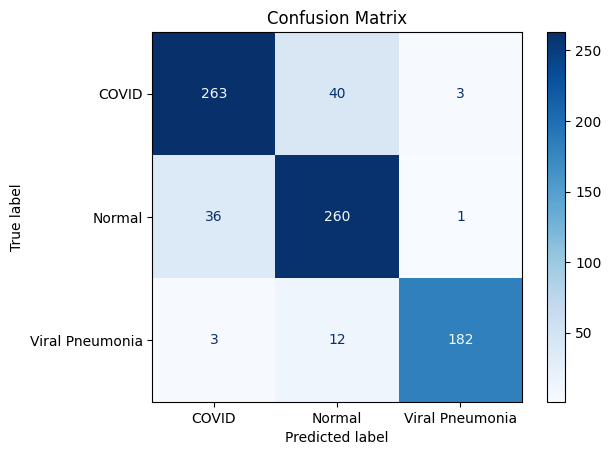

Accuracy: 0.88125
Precision: 0.88125
F1 Score: 0.88125
AUC-ROC Score: 0.9109375000000001
Confusion Matrix:
[[263  40   3]
 [ 36 260   1]
 [  3  12 182]]
*************** Testing learned model done ***************



############### Rollout: 8 of 10 ###############
Value of beta: 0.4782969000000001
7/7 [==============================] - 0s 33ms/step
expert's accuracy = 0.9130434782608695
{'0': 75, '1': 74, '2': 58}
Training for rollout 8 with 3904 of training data
Imitating expert observations
{0: 1691, 1: 1600, 2: 613}
{0: 1.0, 1: 1.056875, 2: 2.7585644371941274}
{0: 1.1, 1: 1.2682499999999999, 2: 2.7585644371941274}
Epoch 1/10
49/49 [==============================] - 6s 100ms/step - loss: 2.8750 - accuracy: 0.5978 - val_loss: 1.1405 - val_accuracy: 0.8015
Epoch 2/10
49/49 [==============================] - 4s 90ms/step - loss: 1.3151 - accuracy: 0.7759 - val_loss: 0.9223 - val_accuracy: 0.8387
Epoch 3/10
49/49 [==============================] - 4s 90ms/step - loss: 1.0765 - accuracy: 0

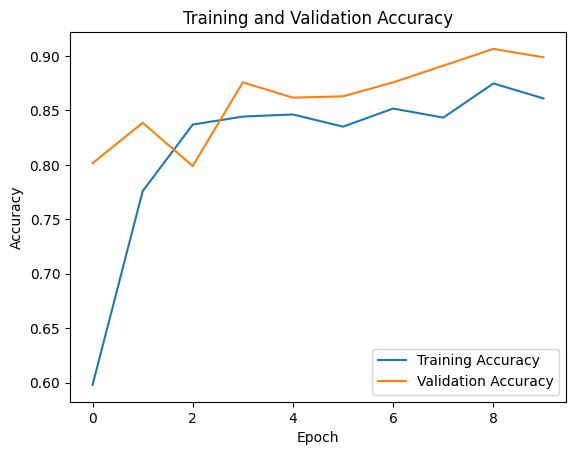

25/25 [==============================] - 1s 34ms/step
Initial Best score:  0.2284165649177251
Training completed for rollout 8

############### Testing learned model ###############
Reward: 186.0, Expected Reward: 207
25/25 [==============================] - 1s 33ms/step


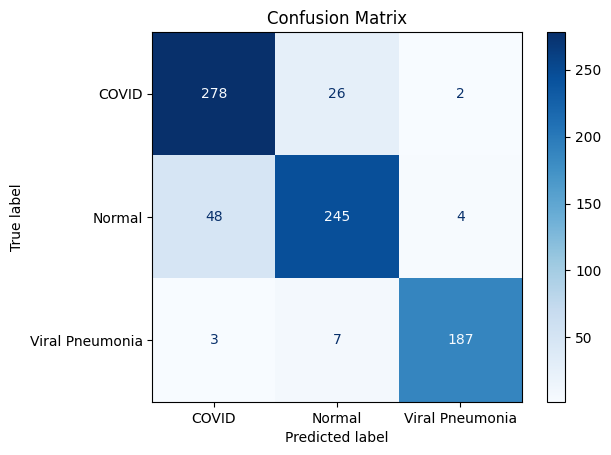

Accuracy: 0.8875
Precision: 0.8875
F1 Score: 0.8875
AUC-ROC Score: 0.9156249999999999
Confusion Matrix:
[[278  26   2]
 [ 48 245   4]
 [  3   7 187]]
*************** Testing learned model done ***************



############### Rollout: 9 of 10 ###############
Value of beta: 0.4304672100000001
7/7 [==============================] - 0s 33ms/step
expert's accuracy = 0.927536231884058
{'0': 77, '1': 86, '2': 44}
Training for rollout 9 with 4111 of training data
Imitating expert observations
{0: 1771, 1: 1687, 2: 653}
{0: 1.0, 1: 1.049792531120332, 2: 2.7120980091883613}
{0: 1.1, 1: 1.2597510373443983, 2: 2.7120980091883613}
Epoch 1/10
52/52 [==============================] - 6s 100ms/step - loss: 2.7491 - accuracy: 0.6068 - val_loss: 1.1574 - val_accuracy: 0.7934
Epoch 2/10
52/52 [==============================] - 5s 91ms/step - loss: 1.3312 - accuracy: 0.7643 - val_loss: 0.9667 - val_accuracy: 0.8032
Epoch 3/10
52/52 [==============================] - 5s 92ms/step - loss: 1.0481 - accura

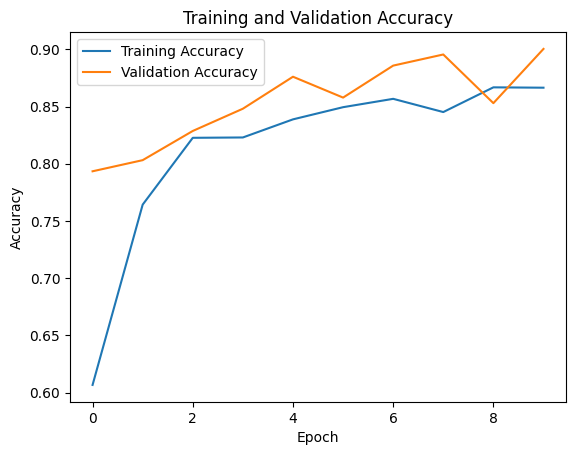

25/25 [==============================] - 1s 33ms/step
Initial Best score:  0.2520647083902142
Training completed for rollout 9

############### Testing learned model ###############
Reward: 185.0, Expected Reward: 207
25/25 [==============================] - 1s 33ms/step


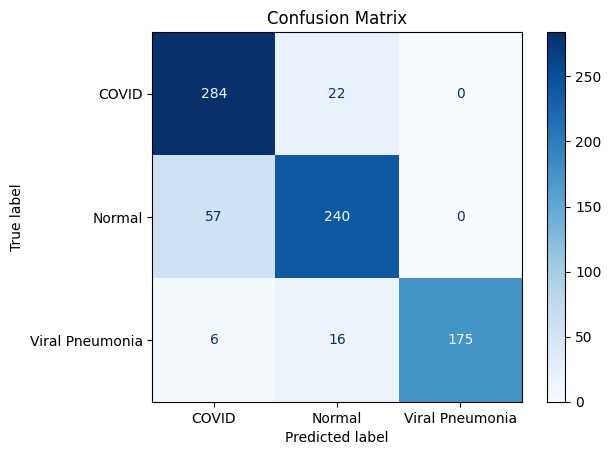

Accuracy: 0.87375
Precision: 0.87375
F1 Score: 0.87375
AUC-ROC Score: 0.9053125000000001
Confusion Matrix:
[[284  22   0]
 [ 57 240   0]
 [  6  16 175]]
*************** Testing learned model done ***************



############### Rollout: 10 of 10 ###############
Value of beta: 0.3874204890000001
1/1 [==============================] - 0s 126ms/step
expert's accuracy = 0.6666666666666666
{'0': 3, '1': 0, '2': 0}
Training for rollout 10 with 4114 of training data
Imitating expert observations
{0: 1773, 1: 1688, 2: 653}
{0: 1.0, 1: 1.0503554502369667, 2: 2.7151607963246556}
{0: 1.1, 1: 1.26042654028436, 2: 2.7151607963246556}
Epoch 1/10
52/52 [==============================] - 6s 96ms/step - loss: 2.9478 - accuracy: 0.5983 - val_loss: 1.1951 - val_accuracy: 0.7691
Epoch 2/10
52/52 [==============================] - 5s 88ms/step - loss: 1.3327 - accuracy: 0.7712 - val_loss: 0.9473 - val_accuracy: 0.8190
Epoch 3/10
52/52 [==============================] - 5s 88ms/step - loss: 1.1138 - accu

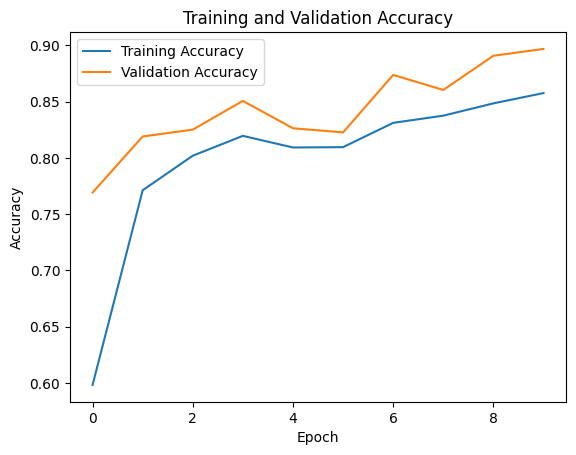

25/25 [==============================] - 1s 33ms/step
Initial Best score:  0.2833039399683804
Training completed for rollout 10

############### Testing learned model ###############
Reward: 2.0, Expected Reward: 3
25/25 [==============================] - 1s 34ms/step


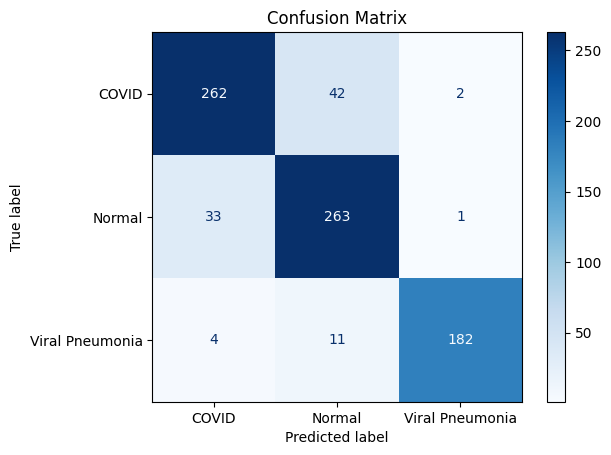

Accuracy: 0.88375
Precision: 0.88375
F1 Score: 0.88375
AUC-ROC Score: 0.9128125
Confusion Matrix:
[[262  42   2]
 [ 33 263   1]
 [  4  11 182]]
*************** Testing learned model done ***************





In [26]:
best_learned_policy = dagger.main()

In [27]:
print("Best learned policy is: {}".format(best_learned_policy))

Best learned policy is: ./models/learned_policy_model_expert_rollout_8.h5
